In [24]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2022-08-03 15:35:14--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.131.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.131.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: 'jena_climate_2009_2016.csv.zip.2'

     0K .......... .......... .......... .......... ..........  0% 6.96M 2s
    50K .......... .......... .......... .......... ..........  0% 4.23M 2s
   100K .......... .......... .......... .......... ..........  1% 4.22M 3s
   150K .......... .......... .......... .......... ..........  1%  247M 2s
   200K .......... .......... .......... .......... ..........  1%  311M 2s
   250K .......... .......... .......... .......... ..........  2% 4.87M 2s
   300K .......... .......... .......... .......... ..........  2%  133M 2s
   350K .......... .......... .......... .......... ..........  3% 87.8M 1s
   400K .....

In [25]:
import pandas as pd
import numpy as np

#Read in file. Create numpy array out of temperature and the rest of the data
df = pd.read_csv('C:/Users/joshu/Documents/TensorFlow Learning Materials/jena_climate_2009_2016.csv/jena_climate_2009_2016.csv')
df.columns = df.columns.str.replace(' ', '_')
temperature = df['T_(degC)'].to_numpy()
raw_data = df[['p_(mbar)', 'Tpot_(K)', 'Tdew_(degC)',
       'rh_(%)', 'VPmax_(mbar)', 'VPact_(mbar)', 'VPdef_(mbar)', 'sh_(g/kg)',
       'H2OC_(mmol/mol)', 'rho_(g/m**3)', 'wv_(m/s)', 'max._wv_(m/s)',
       'wd_(deg)']].to_numpy()

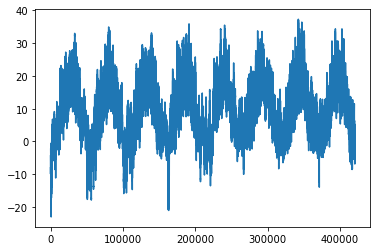

In [26]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

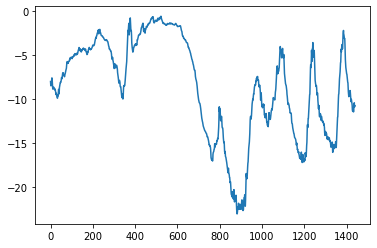

In [27]:
#First 10 days of temperature. Temp recorded every 10 mins. So 144 points per day. 1440 every 10 days.
plt.plot(range(1440), temperature[:1440])

### Can you predict the temperature 24 hours in advance?

In [28]:
#50% train, 25% val, 25% test
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
#want val/test to be more recent than the test set
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [29]:
#normalize the data
mean = raw_data[:num_train_samples].mean(axis = 0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

samples are highly redundent in time series use keras function to reduce computational load
For example, if you use data = [0 1 2 3 4 5 6] and sequence_length=3, then timeseries_dataset_from_array() will generate the following samples: [0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6].
The first entry of the targets array should match the desired target for the first sequence that will be generated from the data array. 
For instance, with data = [0 1 2 3 4 5 6 ...] and sequence_length=3, you could create a dataset to predict the next step in the series by passing targets = [3 4 5 6 ...]

In [30]:
from tensorflow import keras
#array of sorted integers
int_sequence = np.arange(10)
#keras function to reduce computation, creates offset for data so not as much of it gets stored in memory
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    #sample from 0 - 6
        data = int_sequence[:-3],
    #start at 3 end at 9
        targets = int_sequence[3:],
    #3 step long sequence
        sequence_length = 3, 
    #batches of size 2
        batch_size = 2
)

for inputs, targets in dummy_dataset:
        for i in range(inputs.shape[0]):
            print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [31]:
#Create dataset for training, val, and testing
#sample_rate = 6 - one datapoint per hour
sampling_rate = 6
#obs go back 5 days (120 hrs)
sequence_length = 120
#delay is the target for the sequence. Its a temp 24hrs after end of sequence
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)
#Creates a tuple of (samples, targets) where samples is a batch of 256 containing 120 consecutive hrs of input data
#targets is an array of 256 target temps. Samples are shuffled so two consecutive sequences in a batch are not temporally close.

### Evaluate Densely Connected Model as Baseline

In [33]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation = "relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only = True)]

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])

history = model.fit(train_dataset, epochs = 10, validation_data = val_dataset,
                   callbacks = callbacks)
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 18ms/step - loss: 12.4733 - mae: 2.7468 - val_loss: 10.1240 - val_mae: 2.5157
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 9.0000 - mae: 2.3639 - val_loss: 10.4805 - val_mae: 2.5571
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 8.2768 - mae: 2.2717 - val_loss: 12.0884 - val_mae: 2.7539
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 7.7615 - mae: 2.1999 - val_loss: 10.5283 - val_mae: 2.5633
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 7.4494 - mae: 2.1551 - val_loss: 13.7005 - val_mae: 2.9454
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 7.1819 - mae: 2.1169 - val_loss: 10.9494 - val_mae: 2.6133
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 6.9644 - mae: 2.0812 - val_loss: 10.8421 - val_mae: 2.5935
Epoch 8/10
819/819 [==============================] - 

<Figure size 432x288 with 0 Axes>

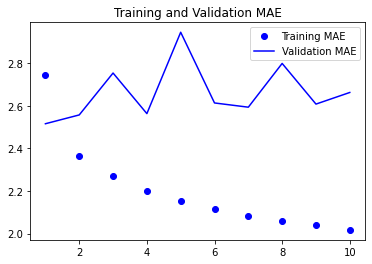

In [34]:
plt.clf()
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training MAE")
plt.plot(epochs, val_loss, "b", label = "Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

### 1D Conv Net Model

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
#Choose initial window length of 24 to look at 24 hours of data. 
#As downsample reduce the window size
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 19ms/step - loss: 27.3627 - mae: 4.0128 - val_loss: 19.4345 - val_mae: 3.5220
Epoch 2/10
819/819 [==============================] - 16s 19ms/step - loss: 15.9280 - mae: 3.1701 - val_loss: 14.2171 - val_mae: 2.9790
Epoch 3/10
819/819 [==============================] - 16s 20ms/step - loss: 14.2989 - mae: 3.0013 - val_loss: 16.9444 - val_mae: 3.2405
Epoch 4/10
819/819 [==============================] - 18s 21ms/step - loss: 13.3716 - mae: 2.8991 - val_loss: 15.6208 - val_mae: 3.1007
Epoch 5/10
819/819 [==============================] - 17s 20ms/step - loss: 12.7289 - mae: 2.8262 - val_loss: 14.1407 - val_mae: 2.9848
Epoch 6/10
819/819 [==============================] - 17s 21ms/step - loss: 12.2026 - mae: 2.7650 - val_loss: 15.8370 - val_mae: 3.1476
Epoch 7/10
819/819 [==============================] - 16s 19ms/step - loss: 11.7942 - mae: 2.7155 - val_loss: 14.4957 - val_mae: 2.9980
Epoch 8/10
819/819 [============================

<Figure size 432x288 with 0 Axes>

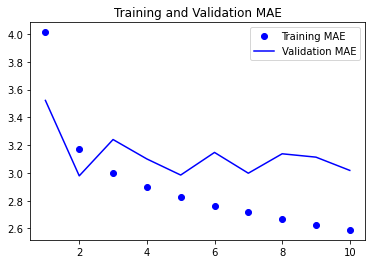

In [36]:
#This model performs worse than the previous.
plt.clf()
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training MAE")
plt.plot(epochs, val_loss, "b", label = "Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

#### Performs worse because timeseries conv does not respect translation invariance assumption. Temperture does feature daily cycles but, days follow different properties from nights. Also max pooling and global average pooling destroy the order of the information.

### Recurrent Neural Networks - LSTM

In [37]:
#Simple LSTM model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                   epochs = 10, 
                   validation_data=val_dataset,
                   callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 25s 27ms/step - loss: 44.0416 - mae: 4.8199 - val_loss: 13.0296 - val_mae: 2.7375
Epoch 2/10
819/819 [==============================] - 20s 25ms/step - loss: 11.1614 - mae: 2.5912 - val_loss: 9.6771 - val_mae: 2.4295
Epoch 3/10
819/819 [==============================] - 21s 26ms/step - loss: 9.8783 - mae: 2.4544 - val_loss: 9.7593 - val_mae: 2.4520
Epoch 4/10
819/819 [==============================] - 20s 25ms/step - loss: 9.4280 - mae: 2.3936 - val_loss: 9.7684 - val_mae: 2.4423
Epoch 5/10
819/819 [==============================] - 19s 24ms/step - loss: 9.0627 - mae: 2.3439 - val_loss: 9.9128 - val_mae: 2.4628
Epoch 6/10
819/819 [==============================] - 20s 24ms/step - loss: 8.8026 - mae: 2.3086 - val_loss: 9.8683 - val_mae: 2.4492
Epoch 7/10
819/819 [==============================] - 20s 25ms/step - loss: 8.5919 - mae: 2.2783 - val_loss: 9.9489 - val_mae: 2.4720
Epoch 8/10
819/819 [==============================] - 21s 2

<Figure size 432x288 with 0 Axes>

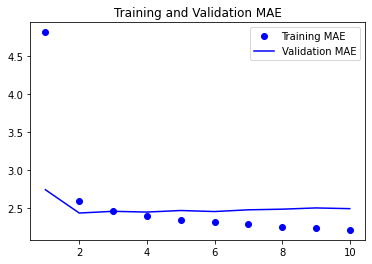

In [38]:
#Performs alot better!
plt.clf()
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training MAE")
plt.plot(epochs, val_loss, "b", label = "Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

### RNN Keras Features

In [39]:
#RNN that returns only its last output step (works for lstm/gru) i.e. (batchsize, output features)
num_features = 14
steps = 120
#Can set steps to none if you dont want to specify length of timestep to process
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [40]:
#RNN that returns full output sequence - (batchsize, timesteps, output features)
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences = True)(inputs)
print(outputs.shape)

(None, 120, 16)


#### Recurrent Dropout

In [42]:
#Recurrent dropout works differently than regular dropout. Rather than a random mask on the weights.
#Recurrent dropout creates a mask over each timestep 

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout = 0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callback = [keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                           save_best_only = True)]

model.compile(optimizer = "rmsprop", loss ="mse", metrics = ["mae"])
history = model.fit(train_dataset,
                   epochs = 50,
                   validation_data = val_dataset,
                   callbacks = callbacks)

Epoch 1/50
819/819 [==============================] - 405s 492ms/step - loss: 30.3355 - mae: 4.0439 - val_loss: 9.9755 - val_mae: 2.4633
Epoch 2/50
819/819 [==============================] - 401s 490ms/step - loss: 14.8820 - mae: 2.9926 - val_loss: 9.3420 - val_mae: 2.3735
Epoch 3/50
819/819 [==============================] - 416s 508ms/step - loss: 14.0532 - mae: 2.9022 - val_loss: 9.4583 - val_mae: 2.3928
Epoch 4/50
819/819 [==============================] - 413s 505ms/step - loss: 13.4816 - mae: 2.8463 - val_loss: 9.3165 - val_mae: 2.3650
Epoch 5/50
819/819 [==============================] - 417s 509ms/step - loss: 12.9294 - mae: 2.7886 - val_loss: 9.1299 - val_mae: 2.3465
Epoch 6/50
819/819 [==============================] - 411s 501ms/step - loss: 12.4804 - mae: 2.7400 - val_loss: 9.4262 - val_mae: 2.4052
Epoch 7/50
819/819 [==============================] - 424s 517ms/step - loss: 12.1270 - mae: 2.7043 - val_loss: 9.5717 - val_mae: 2.4359
Epoch 8/50
819/819 [=====================

KeyboardInterrupt: 

In [ ]:
#The above is considerably slower because recurrent dropout is not supported by the NVIDIA kernel
#Can use unrolling to try and speed up but it increases memory consumption and is only reccomended for small sequences

#Sequence length cannot be none
input = keras.Input(shape=(sequence_length, num_features))
#Make unrolling = true
x = layers.LSTM(32, recurrent_dropout = 0.2, unroll = True)(inputs)

#### Stacking Layers Example

In [ ]:
#droupout regularized, stacked GRU Model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout = 0.5, return_sequences = True)(inputs)
x = layers.GRU(32, recurrent_dropout = 0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                            save_best_only = True)]

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])
history = model.fit(train_dataset,
                   epochs = 50,
                   validation_data = val_dataset,
                   callbacks = callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]: .2f}")

#### Bidirectional RNN Example

In [43]:
#Bidirectional LSTM example - this underperforms but works well on task order matters but which order does not matter!
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer = "rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                   epochs = 10,
                   validation_data = val_dataset)

Epoch 1/10
819/819 [==============================] - 33s 37ms/step - loss: 25.8015 - mae: 3.6772 - val_loss: 10.4899 - val_mae: 2.4879
Epoch 2/10
819/819 [==============================] - 30s 36ms/step - loss: 9.3960 - mae: 2.3958 - val_loss: 10.2202 - val_mae: 2.4603
Epoch 3/10
819/819 [==============================] - 30s 37ms/step - loss: 8.5974 - mae: 2.2836 - val_loss: 10.1329 - val_mae: 2.4531
Epoch 4/10
819/819 [==============================] - 28s 34ms/step - loss: 8.1440 - mae: 2.2224 - val_loss: 10.2693 - val_mae: 2.4667
Epoch 5/10
819/819 [==============================] - 35s 43ms/step - loss: 7.7557 - mae: 2.1711 - val_loss: 9.7934 - val_mae: 2.4226
Epoch 6/10
819/819 [==============================] - 28s 35ms/step - loss: 7.4125 - mae: 2.1235 - val_loss: 10.7453 - val_mae: 2.5091
Epoch 7/10
819/819 [==============================] - 29s 35ms/step - loss: 7.0837 - mae: 2.0759 - val_loss: 10.6395 - val_mae: 2.5042
Epoch 8/10
819/819 [==============================] - 2